In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, log_loss
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import shap

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv

#load the preprocessed data
X_train = pd.read_csv("X_train_bin.csv")
X_test = pd.read_csv("X_test_bin.csv")
y_train = pd.read_csv("y_train_bin.csv").squeeze()
y_test = pd.read_csv("y_test_bin.csv").squeeze()

In [2]:
#define the XGBoost model with the best parameters
xgb_model_best = xgb.XGBClassifier(
    learning_rate=np.float64(0.05286004537658223),
    max_depth=4,
    n_estimators=1382,
    subsample=np.float64(0.8259278817295955),
    device='cuda'  # keep using GPU if available
)

start_time = time.perf_counter()

#train the model on the training data
xgb_model_best.fit(X_train, y_train)

end_time = time.perf_counter()

training_time = end_time - start_time
print(f"\nTraining (convergence) time: {training_time} seconds")


Training (convergence) time: 17.324341599996842 seconds


In [4]:
#predict on the test set
y_pred = xgb_model_best.predict(X_test)
y_pred_proba = xgb_model_best.predict_proba(X_test)[:, 1]

In [5]:
#calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Log Loss: {logloss}")

Accuracy: 0.9999680727430622
Recall: 0.9998864571801641
Precision: 0.9999716118775904
F1 Score: 0.9999290327159179
ROC AUC: 0.9999999615293799
Log Loss: 0.00013689076631009234


In [6]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242754
           1       1.00      1.00      1.00     70458

    accuracy                           1.00    313212
   macro avg       1.00      1.00      1.00    313212
weighted avg       1.00      1.00      1.00    313212



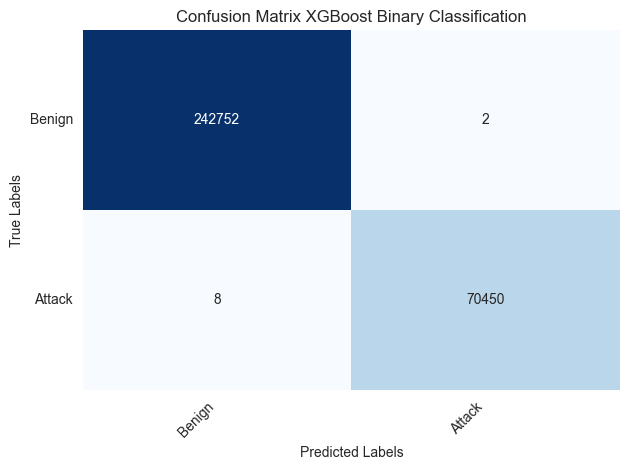

In [7]:
labels = [
    'Benign',
    'Attack'
]
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix XGBoost Binary Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
#export result before shap
#export xgb_best results
results_list = ["xgb_bin", training_time, accuracy, recall, precision, f1, roc_auc, logloss, tn, fp, fn, tp]
file_path = 'results.csv'

# Check if the file exists to avoid duplicate headers
file_exists = os.path.isfile(file_path)

# Open and write to the file
with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data row
    writer.writerow(results_list)

In [9]:
# SHAP Analysis
explainer = shap.TreeExplainer(xgb_model_best)
shap_values = explainer(X_test)

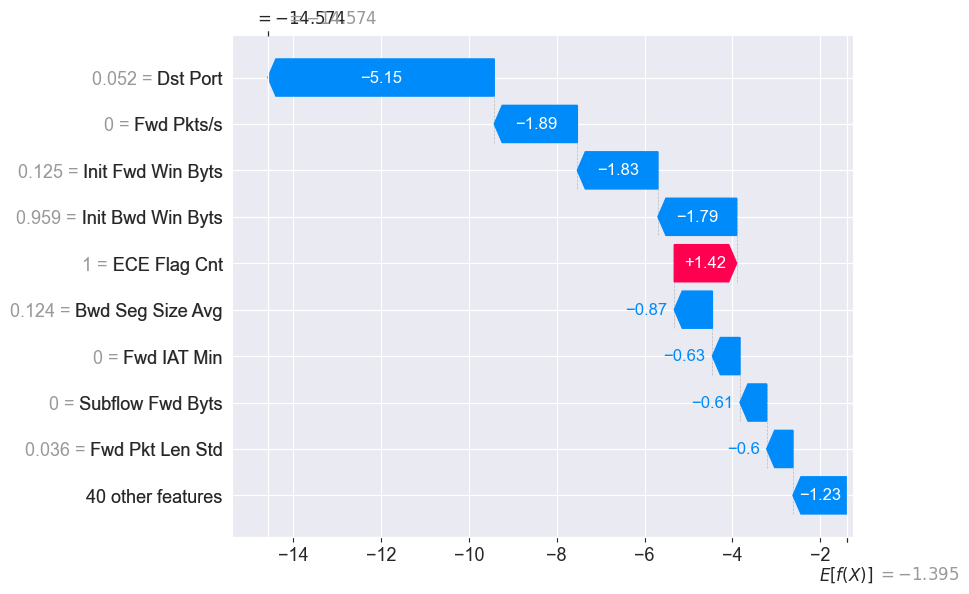

In [10]:
# Visualize SHAP values for the first instance
shap.plots.waterfall(shap_values[0])

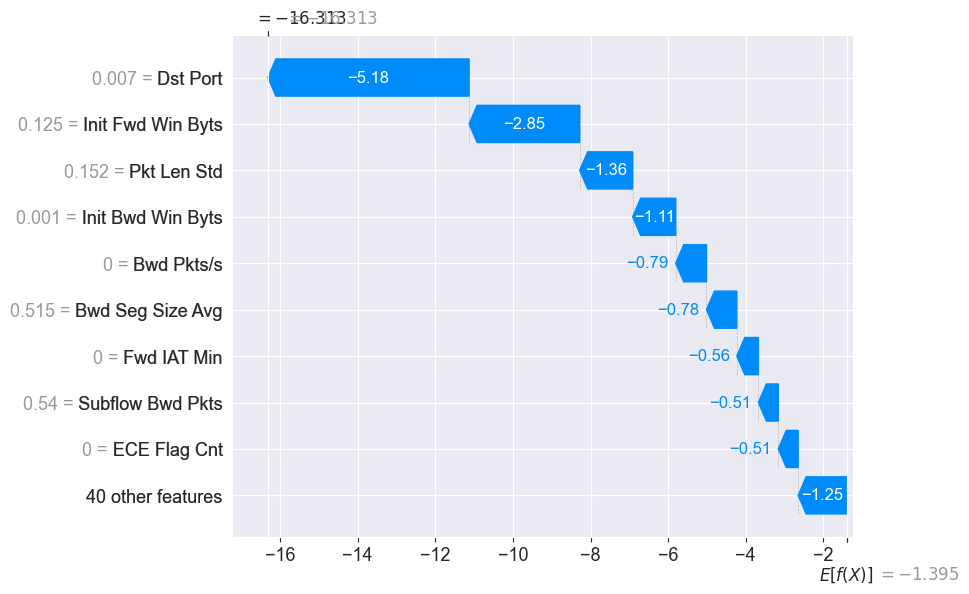

In [11]:
# Visualize SHAP values for a specific instance
shap.plots.waterfall(shap_values[16])

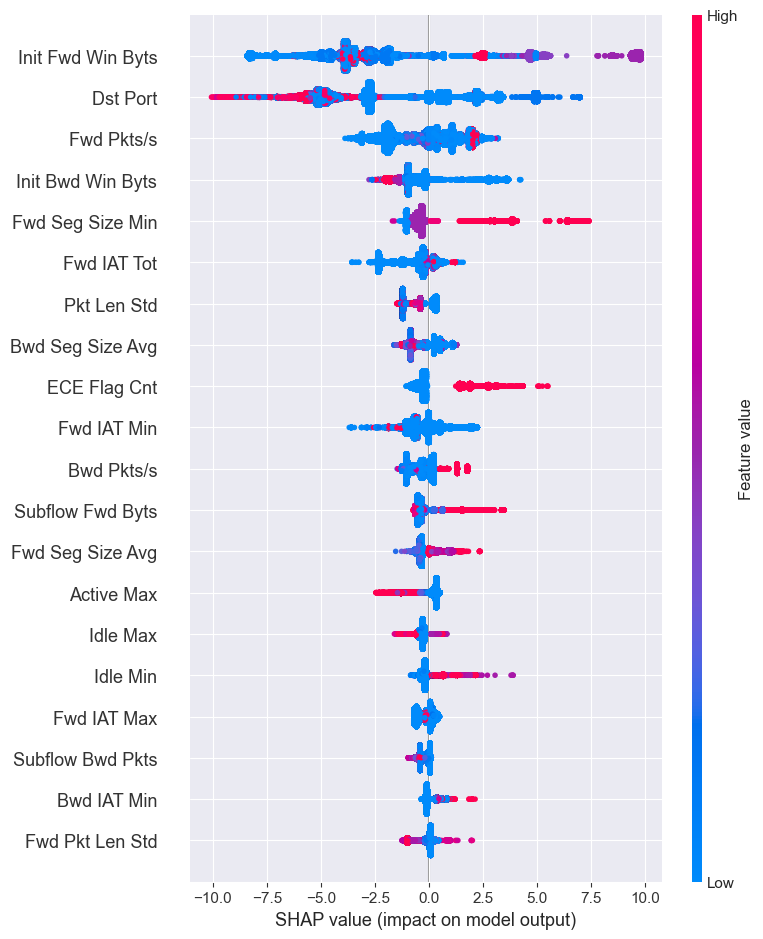

In [12]:
# Summary Plot: Feature importance and effects
shap.summary_plot(shap_values, X_test)

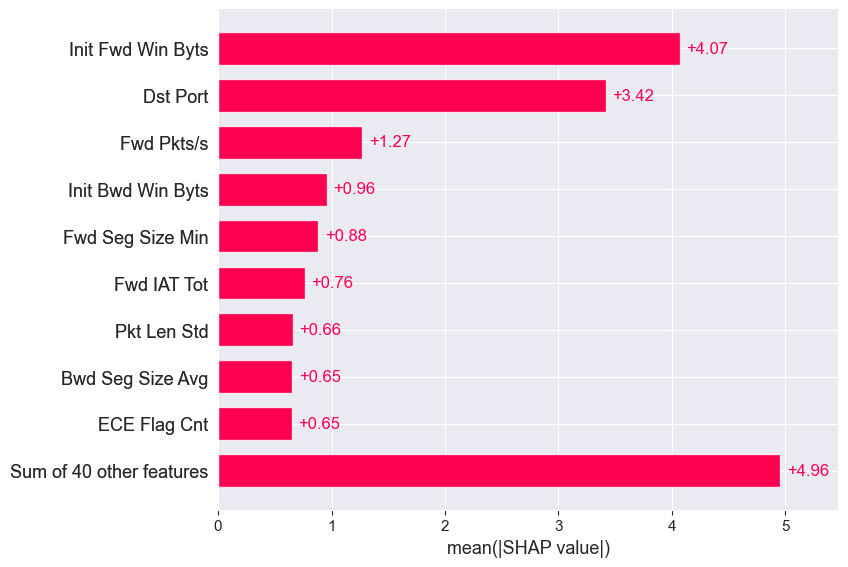

In [13]:
# Bar Plot: Mean absolute SHAP values for each feature
shap.plots.bar(shap_values)

In [14]:
# Sort features by mean absolute SHAP value
mean_shap = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean_SHAP': mean_shap
}).sort_values('Mean_SHAP', ascending=False)

print("\nMean Absolute SHAP Values (Feature Importance):")
print(feature_importance.to_string())

# Select features above a threshold
threshold = 0.05
# Identify the least significant features based on the threshold
least_significant = feature_importance[feature_importance['Mean_SHAP'] < threshold]['Feature'].tolist()


Mean Absolute SHAP Values (Feature Importance):
              Feature  Mean_SHAP
40  Init Fwd Win Byts   4.069043
0            Dst Port   3.419374
17         Fwd Pkts/s   1.269952
41  Init Bwd Win Byts   0.955664
43   Fwd Seg Size Min   0.882602
5         Fwd IAT Tot   0.764847
20        Pkt Len Std   0.659173
30   Bwd Seg Size Avg   0.652562
28       ECE Flag Cnt   0.649465
8         Fwd IAT Min   0.608735
18         Bwd Pkts/s   0.554586
37   Subflow Fwd Byts   0.470250
29   Fwd Seg Size Avg   0.416101
45         Active Max   0.355161
47           Idle Max   0.318209
48           Idle Min   0.264056
7         Fwd IAT Max   0.244603
38   Subflow Bwd Pkts   0.229753
13        Bwd IAT Min   0.228749
2     Fwd Pkt Len Std   0.217146
4         Flow Byts/s   0.163344
6        Fwd IAT Mean   0.147142
46         Active Min   0.102714
11        Bwd IAT Std   0.100266
22       FIN Flag Cnt   0.094699
25       ACK Flag Cnt   0.086639
3     Bwd Pkt Len Min   0.077578
19        Pkt Len Min   0.0

In [15]:
#drop the least significant features from the training and test sets
print(f"Dropping {len(least_significant)} least significant features")

X_train_reduced = X_train.drop(columns=least_significant)
X_test_reduced = X_test.drop(columns=least_significant)

Dropping 20 least significant features


In [16]:
#define a new XGBoost model with reduced features
xgb_model_reduced = xgb.XGBClassifier(
    learning_rate=np.float64(0.05286004537658223),
    max_depth=4,
    n_estimators=1382,
    subsample=np.float64(0.8259278817295955),
    device='cuda'  # keep using GPU if available
)

start_time_red = time.perf_counter()

#train the model on the reduced training data
xgb_model_reduced.fit(X_train_reduced, y_train)

end_time_red = time.perf_counter()

training_time_red = end_time_red - start_time_red
print(f"\nTraining (convergence) time: {training_time_red} seconds")


Training (convergence) time: 12.288867399998708 seconds


In [17]:
#predict on the reduced test set
y_pred_reduced = xgb_model_reduced.predict(X_test_reduced)
y_pred_proba_reduced = xgb_model_reduced.predict_proba(X_test_reduced)[:, 1]

In [18]:
#calculate evaluation metrics for the reduced model
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
recall_reduced = recall_score(y_test, y_pred_reduced)
precision_reduced = precision_score(y_test, y_pred_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced)
roc_auc_reduced = roc_auc_score(y_test, y_pred_proba_reduced)
logloss_reduced = log_loss(y_test, y_pred_proba_reduced)

print(f"Accuracy: {accuracy_reduced}")
print(f"Recall: {recall_reduced}")
print(f"Precision: {precision_reduced}")
print(f"F1 Score: {f1_reduced}")
print(f"ROC AUC: {roc_auc_reduced}")
print(f"Log Loss: {logloss_reduced}")

Accuracy: 0.999971265468756
Recall: 0.9998864571801641
Precision: 0.999985805737321
F1 Score: 0.999936128991051
ROC AUC: 0.9999999613539818
Log Loss: 0.00013449617596576234


In [19]:
print("Classification Report:")
print(classification_report(y_test, y_pred_reduced))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242754
           1       1.00      1.00      1.00     70458

    accuracy                           1.00    313212
   macro avg       1.00      1.00      1.00    313212
weighted avg       1.00      1.00      1.00    313212



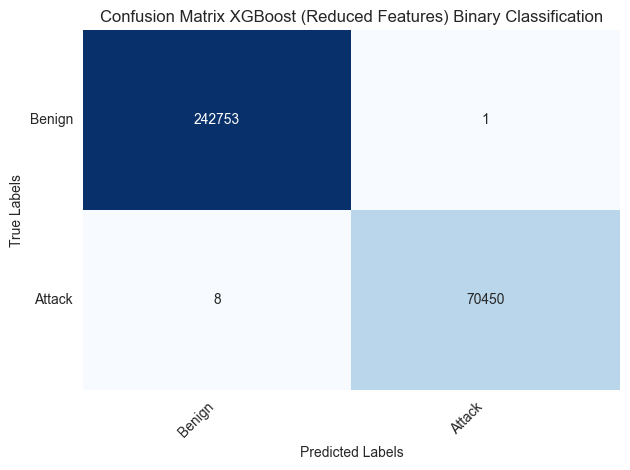

In [20]:
labels = [
    'Benign',
    'Attack'
]
cm_red = confusion_matrix(y_test, y_pred_reduced)
tn_red, fp_red, fn_red, tp_red = cm_red.ravel()
sns.heatmap(cm_red, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix XGBoost (Reduced Features) Binary Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
#export result after shap
#export xgb_reduced results
results_list = ["xgb_bin_reduced", training_time_red, accuracy_reduced, recall_reduced, precision_reduced, f1_reduced, roc_auc_reduced, logloss_reduced, tn_red, fp_red, fn_red, tp_red]
file_path = 'results.csv'

# Check if the file exists to avoid duplicate headers
file_exists = os.path.isfile(file_path)

# Open and write to the file
with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data row
    writer.writerow(results_list)

In [22]:
k = 30
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [23]:
# Correct cross-validation setup
scores = cross_val_score(
    xgb_model_best,
    X_train,
    y_train,
    cv=kf,
    scoring='recall'
)

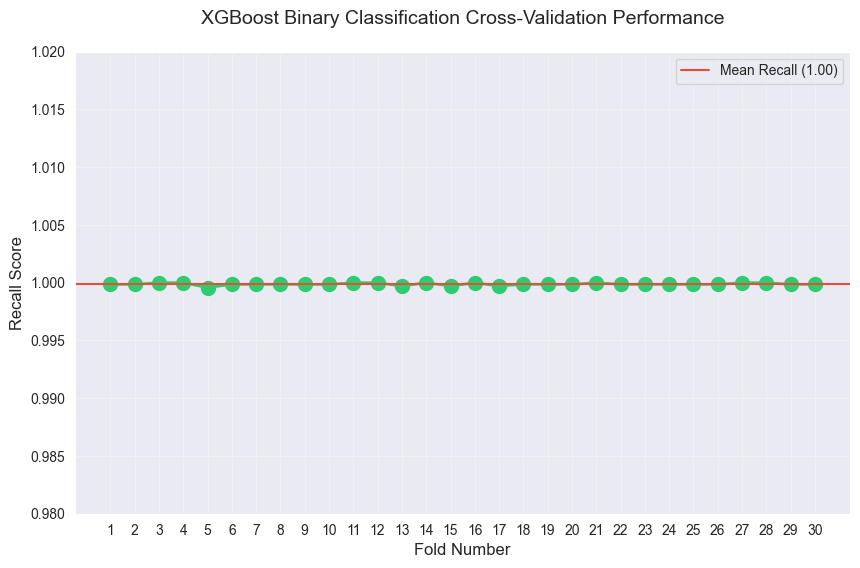

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores)+1), scores, marker='o', linestyle='-', color='#2ecc71', linewidth=2, markersize=10)
plt.axhline(y=np.mean(scores), color='#e74c3c', linestyle='-', label=f'Mean Recall ({np.mean(scores):.2f})')

# Formatting
plt.title('XGBoost Binary Classification Cross-Validation Performance', fontsize=14, pad=20)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)
plt.xticks(range(1, len(scores)+1))
plt.ylim(0.98, 1.02)  # Adjusted for your score range
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [25]:
# Correct cross-validation setup
scores_reduced = cross_val_score(
    xgb_model_reduced,
    X_train_reduced,
    y_train,
    cv=kf,
    scoring='recall'
)

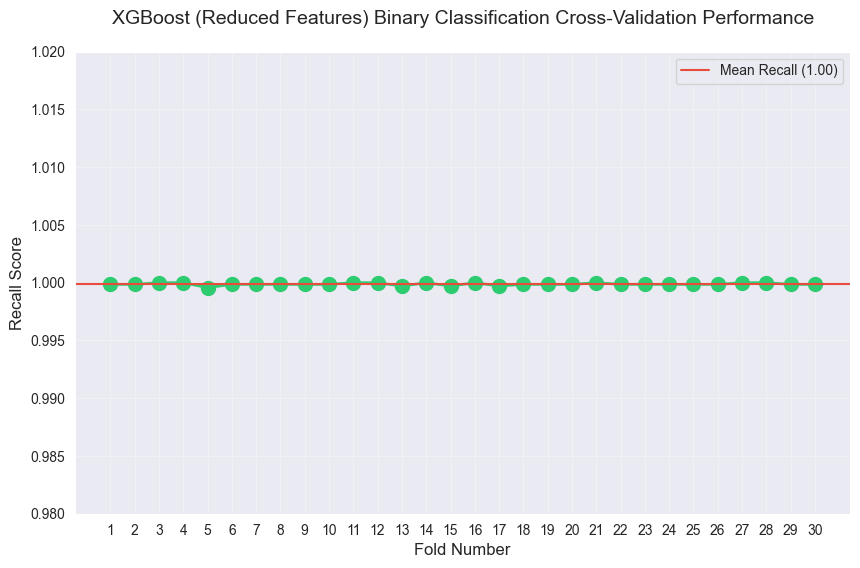

In [26]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores_reduced)+1), scores_reduced, marker='o', linestyle='-', color='#2ecc71', linewidth=2, markersize=10)
plt.axhline(y=np.mean(scores_reduced), color='#e74c3c', linestyle='-', label=f'Mean Recall ({np.mean(scores_reduced):.2f})')

# Formatting
plt.title('XGBoost (Reduced Features) Binary Classification Cross-Validation Performance', fontsize=14, pad=20)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)
plt.xticks(range(1, len(scores_reduced)+1))
plt.ylim(0.98, 1.02)  # Adjusted for your score range
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()